<a href="https://colab.research.google.com/github/prasanth5reddy/GANs/blob/master/Vanilla/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/GANs/'
sys.path.append(w_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip3 install torch torchvision

Importing Libraries

In [0]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets, utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time

To use or not use CUDA

In [4]:
use_cuda = True
cuda = True if use_cuda and torch.cuda.is_available() else False
cuda

True

Dataset

In [0]:
def mnist_data():
  compose = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])])
  out_dir = w_dir + 'data'
  return datasets.MNIST(root=out_dir, download=True, train=True, transform=compose)

data = mnist_data()
batch_size = 128
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

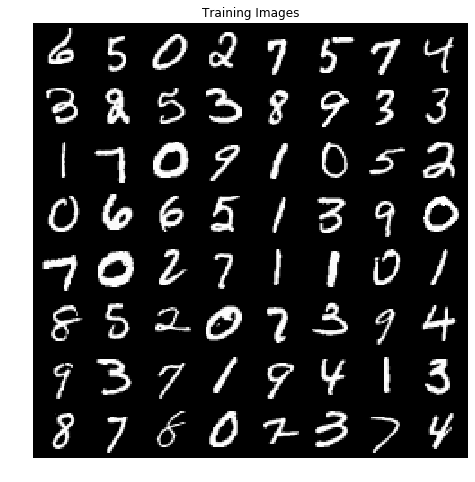

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cuda()[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Networks

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # since the input image size is 28x28
    n_inputs = 784
    n_out = 1
    
    self.layer_1 = nn.Sequential(
      nn.Linear(n_inputs, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3))
    
    self.layer_2 = nn.Sequential(
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3))
    
    self.layer_3 = nn.Sequential(
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3))
    
    self.layer_4 = nn.Sequential(
      nn.Linear(256, n_out),
      nn.Sigmoid())
    
  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    return x

def images_to_vectors(images):
  return images.view(images.size(0), -1)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # number of inputs is called latent dimension
    n_inputs = 100
    n_out = 784
    
    self.layer_1 = nn.Sequential(
      nn.Linear(n_inputs, 256),
      nn.LeakyReLU(0.2))
    
    self.layer_2 = nn.Sequential(
      nn.Linear(256, 512),
      nn.LeakyReLU(0.2))
    
    self.layer_3 = nn.Sequential(
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2))
    
    self.layer_4 = nn.Sequential(
      nn.Linear(1024, n_out),
      nn.Tanh())
    
  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    return x
  
def noise(size):
  noise = Variable(torch.randn(size, 100))
  return noise.cuda() if cuda else noise

In [0]:
generator = Generator()
discriminator = Discriminator()
if cuda:
  generator.cuda()
  discriminator.cuda()

Optimizers

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 100

Generate labels

In [0]:
def real_label(size):
  data = Variable(torch.ones(size, 1))
  return data.cuda() if cuda else data

def fake_label(size):
  data = Variable(torch.zeros(size, 1))
  return data.cuda() if cuda else data

Train functions

In [0]:
def train_discriminator(X, X_dash, net_D, loss, optim_D):
  optim_D.zero_grad()
  
  real_Y = net_D(X)
  fake_Y = net_D(X_dash)
  
  loss_D = loss(real_Y, real_label(X.size(0))) + loss(fake_Y, fake_label(X.size(0)))
  loss_D.backward()
  
  optim_D.step()
  return torch.sum(loss_D).item()
  

In [0]:
def train_generator(X_dash, net_D, loss, optim_G):
  optim_G.zero_grad()

  fake_Y = net_D(X_dash)
  
  loss_G = loss(fake_Y, real_label(X_dash.size(0)))
  loss_G.backward()
  
  optim_G.step()
  return torch.sum(loss_G).item()

Training

In [14]:
list_loss_G, list_loss_D = [], []
for epoch in range(1, num_epochs + 1):
  start = time.time()
  sum_loss_G, sum_loss_D, num_of_samples = 0, 0, 0
  for i, (imgs, _) in enumerate(dataloader):
    # Train Discriminator
    X = Variable(images_to_vectors(imgs))
    X = X.cuda() if cuda else X
    Z = noise(X.size(0))
    X_dash = generator(Z)
    # Don't want to update weights of generator while training discriminator. Hence, detach()
    loss_D = train_discriminator(X, X_dash.detach(), discriminator, loss, d_optimizer)
    sum_loss_D += loss_D
    
    # Train Generator
    loss_G = train_generator(X_dash, discriminator, loss, g_optimizer)
    sum_loss_G += loss_G
    
    num_of_samples += batch_size
    
#   print(f'Epoch: [{epoch}/{num_epochs}], Batch Number: [{i + 1}/{len(dataloader)}]')
#   print(f'Discriminator Loss: {loss_D}, Generator Loss: {loss_G}')

  loss_dis, loss_gen = sum_loss_D / num_of_samples, sum_loss_G / num_of_samples 
  print(f'Epoch: [{epoch}/{num_epochs}], Run Time: {round(time.time() - start, 4)} Sec')
  print(f'Discriminator Loss: {round(loss_dis, 4)}, Generator Loss: {round(loss_gen, 4)}')
  list_loss_D.append(loss_dis)
  list_loss_G.append(loss_gen)

Epoch: [1/100], Run Time: 10.6485 Sec
Discriminator Loss: 0.0083, Generator Loss: 0.0235
Epoch: [2/100], Run Time: 10.5355 Sec
Discriminator Loss: 0.0059, Generator Loss: 0.0253
Epoch: [3/100], Run Time: 10.5541 Sec
Discriminator Loss: 0.0076, Generator Loss: 0.0155
Epoch: [4/100], Run Time: 10.5982 Sec
Discriminator Loss: 0.0071, Generator Loss: 0.017
Epoch: [5/100], Run Time: 10.708 Sec
Discriminator Loss: 0.0058, Generator Loss: 0.0181
Epoch: [6/100], Run Time: 10.6003 Sec
Discriminator Loss: 0.0036, Generator Loss: 0.0243
Epoch: [7/100], Run Time: 10.5816 Sec
Discriminator Loss: 0.0038, Generator Loss: 0.0247
Epoch: [8/100], Run Time: 10.5787 Sec
Discriminator Loss: 0.0041, Generator Loss: 0.0214
Epoch: [9/100], Run Time: 10.6248 Sec
Discriminator Loss: 0.004, Generator Loss: 0.0222
Epoch: [10/100], Run Time: 10.5671 Sec
Discriminator Loss: 0.004, Generator Loss: 0.0222
Epoch: [11/100], Run Time: 10.5919 Sec
Discriminator Loss: 0.0048, Generator Loss: 0.0194
Epoch: [12/100], Run Ti

Save Parameters

In [0]:
torch.save(generator.state_dict(), w_dir + 'Vanilla/generator.pth')
torch.save(discriminator.state_dict(), w_dir + 'Vanilla/discriminator.pth')

Load Parameters

In [14]:
generator = Generator()
discriminator = Discriminator()
if cuda:
  generator.cuda()
  discriminator.cuda()
  
generator.load_state_dict(torch.load(w_dir + 'Vanilla/generator.pth'))
discriminator.load_state_dict(torch.load(w_dir + 'Vanilla/discriminator.pth'))

generator.eval(), discriminator.eval()

(Generator(
   (layer_1): Sequential(
     (0): Linear(in_features=100, out_features=256, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (layer_2): Sequential(
     (0): Linear(in_features=256, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (layer_3): Sequential(
     (0): Linear(in_features=512, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (layer_4): Sequential(
     (0): Linear(in_features=1024, out_features=784, bias=True)
     (1): Tanh()
   )
 ), Discriminator(
   (layer_1): Sequential(
     (0): Linear(in_features=784, out_features=1024, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Dropout(p=0.3)
   )
   (layer_2): Sequential(
     (0): Linear(in_features=1024, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     (2): Dropout(p=0.3)
   )
   (layer_3): Sequential(
     (0): Linear(in_features=512, out_features=256, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
     

Generate fake images from noise

In [15]:
fake_X = generator(noise(128))
fake_imgs = vectors_to_images(fake_X).detach()
fake_imgs.size()

torch.Size([128, 1, 28, 28])

Display fake images

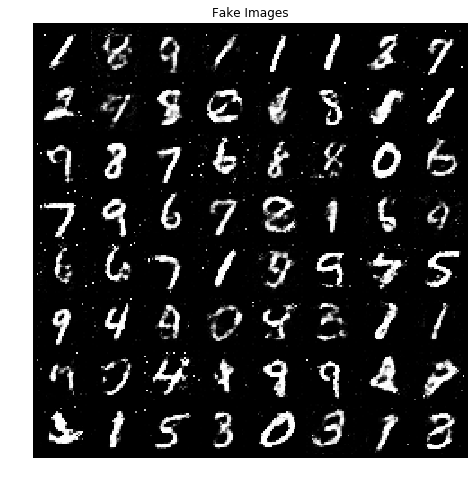

In [16]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_imgs.cuda()[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()